# Answering Business Questions Using SQL

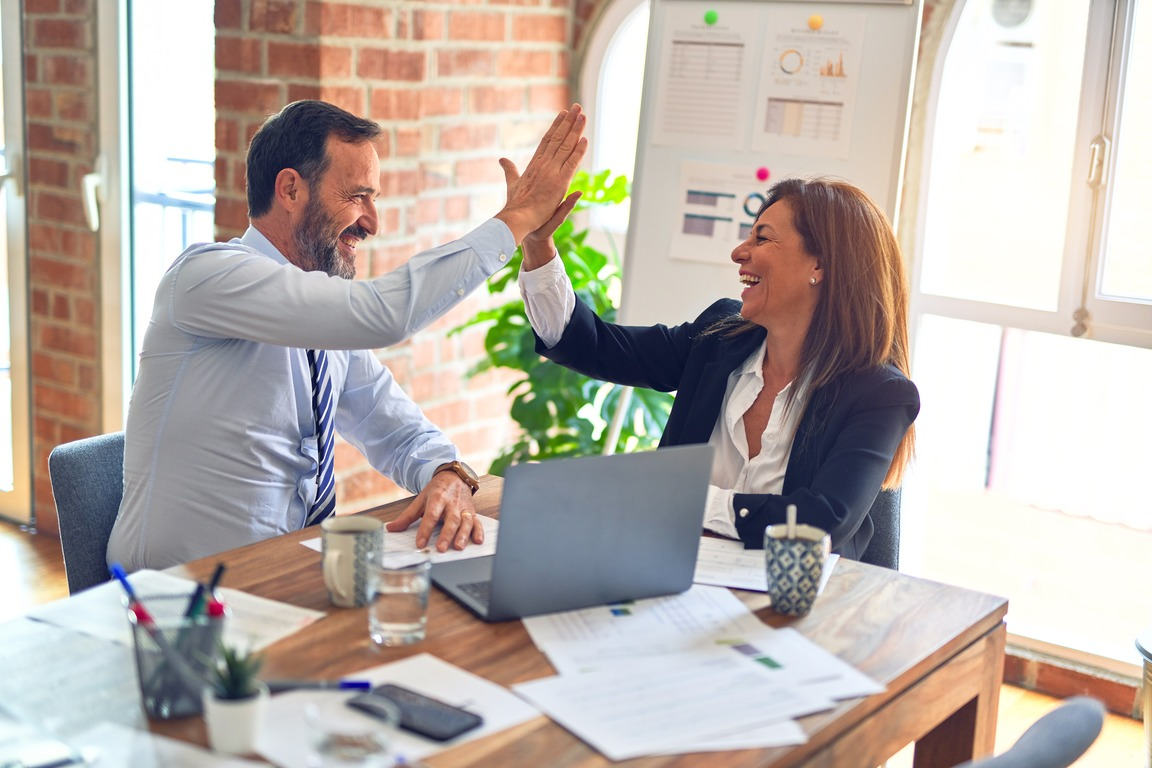

## Introduction

The aim of this project is to explore a modified version of the [Chinook](https://github.com/lerocha/chinook-database) database using SQL and answer the following business questions:
- Which 3 albums of a new record label should be added to the store?
- Which sales support agent performs best of all?
- Which country demonstrates the highest total sales? And the highest number of customers?
- Is the strategy of purchasing only the most popular tracks from each album better than purchasing the whole albums?
- Which artists are used in most playlists?
- How many unique tracks were sold?
- Are protected media types more popular than non-protected ones?

The Chinook database represents a fictional digital media shop based on real data from an iTunes Library and manually generated data. The database is provided as a SQLite database file called `chinook.db`.

Here's a schema diagram for the Chinook database:

![Chinook schema diagram](https://s3.amazonaws.com/dq-content/189/chinook-schema.svg)

## Connecting to the Database and Data Overview

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [2]:
%%sql
SELECT name, type
  FROM sqlite_master
 WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


The database consists of 11 tables containing information about artists, albums, media tracks, playlists, invoices, customers, and shop employees.
## Selecting Albums to Purchase
We'll start by selecting the first three albums (from a list of four) of a new record label that will be added to the store. All 4 albums are by artists that currently don't have any tracks in the store. The available data is represented by the artist names and the genre of music they produce:

| Artist Name          | Genre   |
| -------------------- | ------- |
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, so the new albums will be advertised in the USA. Hence we're interested in finding out which genres sell there the best (the most tracks).

For this purpose, we'll write a query that returns the TOP10 genres with the number and \% of tracks sold in the USA and put them in descending order. The necessary information can be obtained from the `genre`, `track`, `invoice`, and `invoice_line` tables. Then, we'll display the output of this query graphically, using Python's pandas and matplotlib libraries.

,num_tracks,pct
genre,,
Rock,561,53.4
Alternative & Punk,130,12.4
Metal,124,11.8
R&B/Soul,53,5.0
Blues,36,3.4
Alternative,35,3.3
Pop,22,2.1
Latin,22,2.1
Hip Hop/Rap,20,1.9


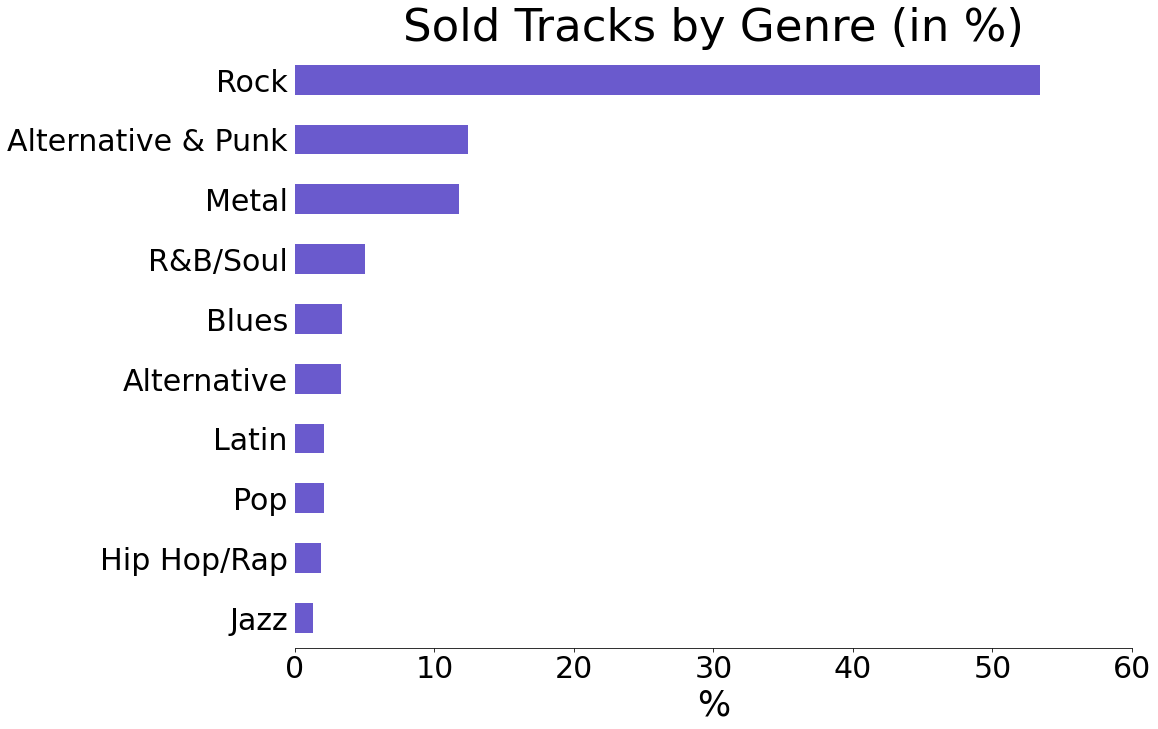

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

query = """
WITH total_count AS (SELECT COUNT(t.track_id) total_count
                       FROM invoice i
                            INNER JOIN invoice_line il
                            ON il.invoice_id = i.invoice_id                            
                            LEFT JOIN track t
                            ON il.track_id = t.track_id    
                            INNER JOIN genre g
                            ON t.genre_id = g.genre_id
                      WHERE i.billing_country = "USA")
                      
SELECT g.name genre,
       COUNT(t.track_id) num_tracks,
       ROUND(COUNT(t.track_id) * 100.00/(SELECT total_count
                                           FROM total_count), 1) pct
  FROM invoice i
       INNER JOIN invoice_line il
       ON il.invoice_id = i.invoice_id        
       LEFT JOIN track t
       ON il.track_id = t.track_id        
       INNER JOIN genre g
       ON t.genre_id = g.genre_id
 WHERE i.billing_country = "USA"
 GROUP BY 1
 ORDER BY 2 DESC
 LIMIT 10;
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn)

# Resetting the index
df = df.set_index("genre", drop=True)

# Plotting tracks sold in the USA by genre in %
fig, ax = plt.subplots(figsize=(15,11))
df["pct"].sort_values().plot.barh(color="slateblue", xlim=(0, 60))
ax.set_title("Sold Tracks by Genre (in %)", fontsize=45)
ax.set_ylabel(None)
ax.set_xlabel("%", fontsize=35)
ax.tick_params(axis="both", labelsize=30, left=False)
sns.despine(left=True)
df

The _most popular genres in the USA_ are **Rock**, **Alternative & Punk**, and **Metal**, followed with a big gap by all the others. Since our choice is limited by Hip-Hop, Punk, Pop, and Blues genres, and since we have to choose 3 out of 4 albums, we can say that only one of the albums to be advertised is related to one of these popular genres (**Punk**). Then, we should select the album of **Blues** genre (5th place by popularity) and the one of **Pop** genre (7th place):

| Artist Name          | Genre   |
| -------------------- | ------- |
| Red Tone             | Punk    |
| Slim Jim Bites       | Blues   |
| Meteor and the Girls | Pop     |

## Analyzing Employee Sales Performance
Each customer in the Chinook store, when they first make a purchase, gets assigned to a sales support agent within the company. We're going to analyze the purchases of customers belonging to each sales support agent, in order to compare their sales performance.

Let's find the total dollar amount of sales assigned to each sales support agent, together with their country, birth date, hire date, and the number and % of customers. The tables to be used here are `employee`, `customer`, and `invoice`. Again, we'll represent this information also in graphical form, using a grouped bar chart. Since we're going to use this kind of chart further in the project, we'll create a function for it.

,country,birthdate,hire_date,customers,pct_customers,total_sales,pct_sales
employee,,,,,,,
Jane Peacock,Canada,1973-08-29 00:00:00,2017-04-01 00:00:00,212,35.0,1732.0,37.0
Margaret Park,Canada,1947-09-19 00:00:00,2017-05-03 00:00:00,214,35.0,1584.0,34.0
Steve Johnson,Canada,1965-03-03 00:00:00,2017-10-17 00:00:00,188,31.0,1394.0,30.0


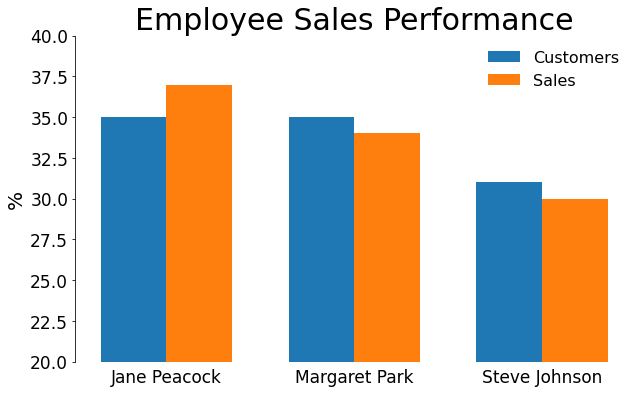

In [4]:
query = """
WITH summary_agents AS (SELECT e.first_name || " " || e.last_name employee,
                               e.country,
                               e.birthdate,
                               e.hire_date,
                               COUNT(c.customer_id) customers,
                               ROUND(SUM(i.total), 0) total_sales
                          FROM employee e
                               LEFT JOIN customer c
                               ON e.employee_id = c.support_rep_id        
                               INNER JOIN invoice i
                               ON c.customer_id = i.customer_id
                         WHERE e.title = "Sales Support Agent"
                         GROUP BY 1
                         ORDER BY 6 DESC)
SELECT employee,
       country,
       birthdate,
       hire_date,
       customers,
       ROUND(customers * 100.0/(SELECT SUM(customers)
                                  FROM summary_agents), 0) pct_customers,
       total_sales,
       ROUND(total_sales * 100.0/(SELECT SUM(total_sales)
                                    FROM summary_agents), 0) pct_sales
  FROM summary_agents;
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("employee", drop=True)
       
# Defining a function for creating a grouped vertical or horizontal bar chart
def plot_grouped_bar_chart(bar_type, fig_width, fig_height,
                           column1, column2,
                           label1, label2,
                           title,
                           xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None,
                           loc=None, bbox_to_anchor=None):
        
    # Converting series to lists
    column1_list = column1.tolist()
    column2_list = column2.tolist()
        
    # Creating labels from the index
    labels = df.index.tolist()
    
    # Specifying the label locations and the width of the bars
    x = np.arange(len(labels))
    width = 0.35
    
    # Plotting the data
    fig, ax = plt.subplots(figsize=(10,6))
    if bar_type=="vertical":
        ax.bar(x-width/2, column1_list, width, label=label1)
        ax.bar(x+width/2, column2_list, width, label=label2)
        ax.set_ylabel("%", fontsize=20)
        ax.set_ylim(ylim_lower, ylim_upper)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=17)
        ax.tick_params(bottom=False, labelsize=17)
        sns.despine(bottom=True)
    elif bar_type=="horizontal":
        ax.barh(x-width/2, column1_list, width, label=label1)
        ax.barh(x+width/2, column2_list, width, label=label2)
        ax.set_xlabel("%", fontsize=20)
        ax.set_xlim(xlim_lower, xlim_upper)
        ax.set_yticks(x)
        ax.set_yticklabels(labels, fontsize=17)
        ax.tick_params(left=False, labelsize=17)
        sns.despine(left=True)
    ax.set_title(title, fontsize=30)
    ax.legend(loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=16, frameon=False)

# Creating a grouped bar chart for % of customers and sales by employee
plot_grouped_bar_chart(bar_type="vertical", fig_width=10, fig_height=6,
                       column1=df["pct_customers"], column2=df["pct_sales"],
                       label1="Customers", label2="Sales",
                       title="Employee Sales Performance",
                       ylim_lower=20, ylim_upper=40, loc=0)
df

There are 3 sales support agents among the employees, they are all from Canada, and were employed in 2017 (April, May, and October). The youngest of them is Jane Peacock, the oldest – Margaret Park.

On one hand, we see a direct correlation between the hire date of a sales support agent and the total amount of sales. However, we also see that the first 2 employees have only 1-month difference in their hire date; moreover, Margaret Park, being hired later, had 2 more customers. Despite that, they have a 3% of difference in their total amounts of sales, whereas Steve Johnson, being hired more than 6 months after Jane Peacock, has only 7% fewer sales than him, and 4% fewer customers.

Given that, Jane Peacock demonstrates the best sales performance, while Margaret Park – the worst.
## Analyzing Sales by Country
Let's now collate data on purchases for customers from different countries, including total number and \% of customers, total value and \% of sales, the average value of sales per customer, average order value. Because in our database there are some countries with only one customer, we'll collect those countries into an "Other" group. The results will be sorted by the total sales in ascending order, with the "Other" group at the bottom of the table, and then displayed as a grouped bar chart. All the data necessary for this analysis is contained in the tables `customer` and `invoice`.

,customers,pct_customers,total_sales,pct_sales,sales_per_customer,avg_order
country,,,,,,
Other,15,25.0,1093.0,23.0,10.0,73.0
USA,13,22.0,1038.0,22.0,10.1,80.0
Canada,8,14.0,535.0,11.0,9.5,67.0
Brazil,5,8.0,427.0,9.0,12.2,85.0
France,5,8.0,388.0,8.0,10.0,78.0
Germany,4,7.0,334.0,7.0,10.3,84.0
Czech Republic,2,3.0,274.0,6.0,15.0,137.0
United Kingdom,3,5.0,245.0,5.0,9.3,82.0
Portugal,2,3.0,185.0,4.0,14.5,93.0


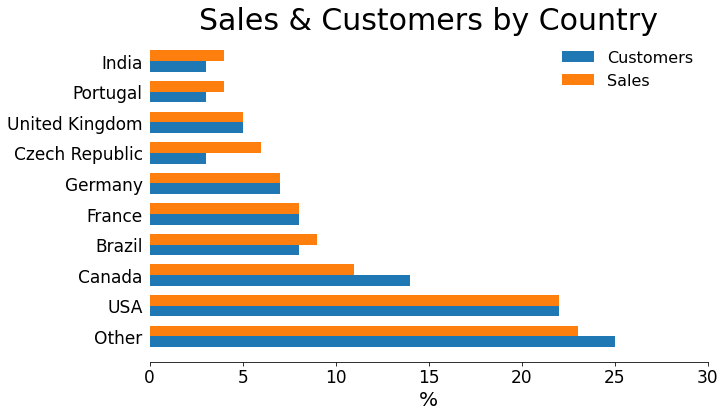

In [5]:
query = """
WITH sales_per_customer AS   (SELECT c.country,
                                     c.customer_id,
                                     ROUND(SUM(i.total), 0) total,
                                     COUNT(i.invoice_id) num_sales
                                FROM customer c
                                     INNER JOIN invoice i
                                     ON i.customer_id = c.customer_id
                               GROUP BY 1, 2),
     all_countries AS        (SELECT c.country,
                                     COUNT(c.customer_id) customers,
                                     ROUND(SUM(spc.total), 0) total_sales,
                                     ROUND(AVG(spc.num_sales), 1) sales_per_customer,
                                     ROUND(AVG(spc.total), 0) avg_order
                                FROM customer c
                                     INNER JOIN sales_per_customer spc
                                     ON spc.customer_id = c.customer_id
                               GROUP BY 1),    
     only_1_customer AS      (SELECT COUNT(country) country,
                                     COUNT(customers) customers,
                                     SUM(total_sales) total_sales,
                                     ROUND(AVG(sales_per_customer), 0) sales_per_customer,
                                     ROUND(AVG(avg_order), 0) avg_order
                                FROM all_countries
                               WHERE customers = 1),        
    other_countries AS       (SELECT CASE
                                     WHEN country = (SELECT country
                                                       FROM only_1_customer)
                                                       THEN "Other"
                                     END AS country,
                                     customers,
                                     total_sales,
                                     sales_per_customer,
                                     avg_order
                                FROM only_1_customer),    
     more_than_1_customer AS (SELECT *
                                FROM all_countries
                               WHERE customers > 1
                               ORDER BY 1),        
     united_unsorted AS      (SELECT * FROM other_countries
                               UNION
                              SELECT * FROM more_than_1_customer)
SELECT country,
       customers,
       ROUND(customers * 100.0/(SELECT SUM(customers)
                                  FROM united_unsorted), 0) pct_customers,
       total_sales,
       ROUND(total_sales * 100.0/(SELECT SUM(total_sales)
                                    FROM united_unsorted), 0) pct_sales,
       sales_per_customer,
       avg_order
  FROM (SELECT united_unsorted.*,
               CASE
               WHEN united_unsorted.country = "Other" THEN 1
               ELSE 0
               END AS sort
          FROM united_unsorted)
 ORDER BY sort DESC, 4 DESC;
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("country", drop=True)

# Creating a grouped bar chart for % of sales and customers by country
plot_grouped_bar_chart(bar_type="horizontal", fig_width=10, fig_height=7,
                       column1=df["pct_customers"], column2=df["pct_sales"],
                       label1="Customers", label2="Sales",
                       title="Sales & Customers by Country",
                       xlim_lower=0, xlim_upper=30, loc=0)
df

The sales by country are evidently dominated by the **USA**, in terms of both the total sales and the number of customers (if not to count the "Other" group). Besides, we can notice a strong positive correlation between the number of customers and the total sales. Interesting that the Czech Republic, having only 2 customers, shows the highest average value of sales per customer and, consequently, the highest average order value. 
## Albums vs. Individual Tracks
In the Chinook store, customers can make purchases in one of the two ways:
- purchase a whole album,
- purchase a collection of one or more individual tracks.

The store doesn't let customers purchase the whole album and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management is currently considering changing their purchasing strategy so that to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album. Our task is to find out what percentage of purchases are individual tracks vs. whole albums. This data will further be used to understand the effect this new strategy might have on overall revenue.

Here we have two edge cases to consider:

- Albums that have only one or two tracks are likely to be purchased by customers as a part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done the analysis to confirm that the second case doesn't happen often, so we can ignore this case also.

To answer our question, we're going to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks, as long as we decided to ignore the second edge case.

In this way, we'll categorize each invoice as a purchase of either a whole album or individual tracks, and calculate the summary statistics for both groups (the number and \% of invoices). For this purpose, we'll use the following tables: `invoice_line`, `track`, and `album`. Then, we'll visualize the results.

,num_invoices,pct
purchase,,
Tracks,500,81.0
Albums,114,19.0


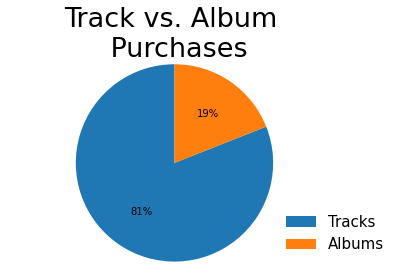

In [6]:
query = """
WITH invoice_album AS   (SELECT il.invoice_id,
                                t.album_id
                           FROM invoice_line il
                                LEFT JOIN track t
                                ON t.track_id = il.track_id
                          GROUP BY 1),
     album_vs_tracks AS (SELECT ia.*,
                                CASE
                                WHEN (SELECT il.track_id
                                        FROM invoice_line il
                                       WHERE il.invoice_id = ia.invoice_id
                                      EXCEPT
                                      SELECT t.track_id
                                        FROM track t
                                       WHERE t.album_id = ia.album_id) IS NULL                             
                                 AND (SELECT t.track_id
                                        FROM track t
                                       WHERE t.album_id = ia.album_id
                                      EXCEPT
                                      SELECT il.track_id
                                        FROM invoice_line il
                                       WHERE il.invoice_id = ia.invoice_id) IS NULL                                   
                                THEN "Albums"
                                ELSE "Tracks"
                                END AS purchase
                           FROM invoice_album ia)                           
SELECT purchase,
       COUNT(*) num_invoices,
       ROUND(COUNT(*) * 100.0 /(SELECT COUNT(*)
                                  FROM invoice), 0) pct
  FROM album_vs_tracks
 GROUP BY 1
 ORDER BY 2 DESC;
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("purchase", drop=True)

# Creating labels from the index
labels = df.index.tolist()

# Selecting data to plot
sizes = df["pct"]

# Plotting the data using a pie chart
fig, ax = plt.subplots()
ax.pie(sizes, autopct="%1.0f%%", startangle=90)
ax.axis("equal")  
ax.set_title("Track vs. Album \n Purchases", fontsize=27, y=0.96)
ax.legend(fontsize=15, labels=labels, bbox_to_anchor=(0.793,0.325), frameon=False)
mpl.rcParams["font.size"] = 18

df

Hence, customers tend to buy **individual tracks** 4 times more often than the whole albums. This means that the new strategy in consideration (purchasing only the most popular tracks from each album from record companies instead of purchasing the whole albums) will definitely help to maximize the overall revenue.
## The Most Popular Artists
Next, we're going to find out which artists are used in most playlists. This information can give us valuable insights on further purchasing strategies of the Chinook store. The tables to be used are `artist`, `album`, `track`, and `playlist_track`.

In [7]:
%%sql
SELECT ar.name artist_name,
       COUNT(DISTINCT(pt.playlist_id)) num_playlists
  FROM artist ar
       INNER JOIN album al
       ON al.artist_id = ar.artist_id        
       INNER JOIN track t
       ON t.album_id = al.album_id    
       INNER JOIN playlist_track pt
       ON pt.track_id = t.track_id
 GROUP BY 1
 ORDER BY 2 DESC
 LIMIT 5;

 * sqlite:///chinook.db
Done.


artist_name,num_playlists
Eugene Ormandy,7
The King's Singers,6
English Concert & Trevor Pinnock,6
Berliner Philharmoniker & Herbert Von Karajan,6
Academy of St. Martin in the Fields & Sir Neville Marriner,6


We got a table of the TOP5 artists, with [Eugene Ormandy](https://en.wikipedia.org/wiki/Eugene_Ormandy) in the first place (present in 7 playlists), followed by 4 other artists (present in 6 playlists). Let's take a look at which genres the tracks of these artists are related:

In [8]:
%%sql
SELECT DISTINCT(g.name) genre
  FROM genre g
       INNER JOIN track t
       ON t.genre_id = g.genre_id    
       INNER JOIN album al
       ON al.album_id = t.album_id    
       INNER JOIN artist ar
       ON ar.artist_id = al.artist_id
 WHERE ar.name = "Eugene Ormandy"
    OR ar.name = "The King's Singers"
    OR ar.name = "English Concert & Trevor Pinnock"
    OR ar.name = "Berliner Philharmoniker & Herbert Von Karajan"
    OR ar.name = "Academy of St. Martin in the Fields & Sir Neville Marriner";

 * sqlite:///chinook.db
Done.


genre
Classical


From one of the previous queries (calculating the number and \% of tracks of each genre sold in the USA), we remember that the classical genre, with all due respect, is far away from being the most sold one. Hence, despite these artists being present in most playlists, a strategy for the Chinook store to buy more tracks of theirs **cannot be considered as potentially profitable** and should be disregarded.
## Purchased vs Not Purchased Tracks
Let's now calculate how many unique tracks were sold.

In [9]:
%%sql
WITH all_vs_sold AS (SELECT COUNT(DISTINCT(t.track_id)) all_tracks,
                            COUNT(DISTINCT(il.track_id)) sold_tracks
                       FROM track t
                            LEFT JOIN invoice_line il
                            ON il.track_id = t.track_id)
SELECT all_vs_sold.*,
       ROUND(sold_tracks * 100.0 / all_tracks, 0) pct_sold
  FROM all_vs_sold;

 * sqlite:///chinook.db
Done.


all_tracks,sold_tracks,pct_sold
3503,1806,52.0


Almost half of all the unique tracks available in the Chinook store were never bought, probably being of unpopular genre or unpopular artists. Possible solutions here may include a new **advertising campaign** (especially in the USA, as the biggest segment of the market), **sales promotion**, additional **training and motivation** of the sales support agents.
## Protected vs Non-Protected Media Types
If a track has a protected media type, it means that it has some associated rules for using its content. It can be encrypted using some form of digital rights management encryption. To play such a file, playback must occur inside the protected media path. In addition, the user might have to acquire the rights to the content.

Let's start by looking at the unique values of media types and whether there are any protected types among them.

In [10]:
%%sql
SELECT DISTINCT(name) AS media_type
  FROM media_type;

 * sqlite:///chinook.db
Done.


media_type
MPEG audio file
Protected AAC audio file
Protected MPEG-4 video file
Purchased AAC audio file
AAC audio file


Two of the five media types are protected. 

Now, we're going to calculate the summary statistics for all protected vs. non-protected media types, and create some charts for them:



               unique_tracks  pct_unique  sold_unique  pct_sold_unique
media_type                                                            
Non-protected           3052        87.0         1652             54.0
Protected                451        13.0          154             34.0


               sold  pct_sold
media_type                   
Non-protected  4315      91.0
Protected       442       9.0




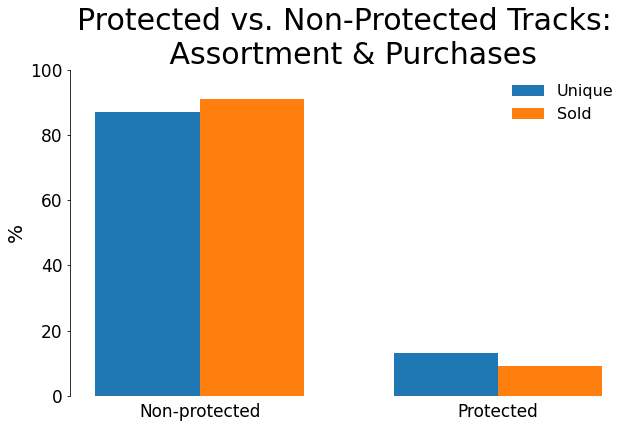

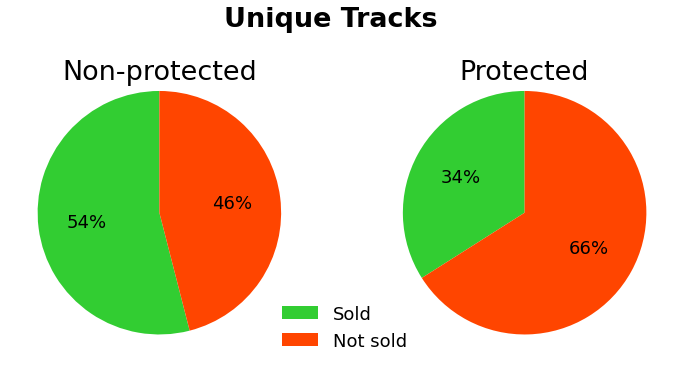

In [11]:
query = """
WITH non_protected AS (SELECT COUNT(mt.name) to_be_renamed,
                              COUNT(DISTINCT(t.track_id)) unique_tracks,
                              COUNT(DISTINCT(il.track_id)) sold_unique,
                              COUNT(il.track_id) sold
                         FROM media_type mt
                              INNER JOIN track t
                              ON mt.media_type_id = t.media_type_id                       
                              LEFT JOIN invoice_line il
                              ON il.track_id = t.track_id
                        WHERE mt.name != "Protected AAC audio file"
                          AND mt.name != "Protected MPEG-4 video file"),
     protected AS     (SELECT COUNT(mt.name) to_be_renamed,
                              COUNT(DISTINCT(t.track_id)) unique_tracks,
                              COUNT(DISTINCT(il.track_id)) sold_unique,
                              COUNT(il.track_id) sold
                         FROM media_type mt
                              INNER JOIN track t
                              ON mt.media_type_id = t.media_type_id                       
                              LEFT JOIN invoice_line il
                              ON il.track_id = t.track_id
                        WHERE mt.name = "Protected AAC audio file"
                           OR mt.name = "Protected MPEG-4 video file"),    
     united AS        (SELECT CASE
                              WHEN to_be_renamed != 0 THEN "Non-protected"
                              END AS media_type,                              
                              unique_tracks,
                              sold_unique,
                              ROUND(sold_unique * 100.0 / unique_tracks, 0) pct_sold_unique,
                              sold
                         FROM non_protected
                        UNION
                       SELECT CASE
                              WHEN to_be_renamed != 0 THEN "Protected"
                              END AS media_type,                       
                              unique_tracks,
                              sold_unique,
                              ROUND(sold_unique * 100.0 / unique_tracks, 0) pct_sold_unique,
                              sold
                         FROM protected)    
SELECT media_type,
       unique_tracks,
       ROUND(unique_tracks * 100.0 / (SELECT SUM(unique_tracks)
                                        FROM united), 0) pct_unique,
       sold_unique,
       pct_sold_unique,
       sold,
       ROUND(sold * 100.0 / (SELECT SUM(sold)
                               FROM united), 0) pct_sold
FROM united;
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("media_type", drop=True)

# Printing the dataframe
print("\n")
print(df.iloc[:, :4])
print("\n")
print(df.iloc[:, 4:])
print("\n")

# Creating a grouped bar chart for protected vs. non-protected tracks
plot_grouped_bar_chart(bar_type="vertical", fig_width=10, fig_height=6,
                       column1=df["pct_unique"], column2=df["pct_sold"],
                       label1="Unique", label2="Sold",
                       title="Protected vs. Non-Protected Tracks: \n Assortment & Purchases",
                       ylim_lower=0, ylim_upper=100, loc=0)
plt.show()
print("\n")

# Creating a new dataframe for pie charts
df1 = df[["pct_sold_unique"]].copy()
df1[["pct_not_sold_unique"]] = 100 - df1[["pct_sold_unique"]]
df1 = df1.transpose()

# Creating labels
labels = ["Sold", "Not sold"]

# Selecting data to plot
sizes_1 = df1["Non-protected"]
sizes_2 = df1["Protected"]

# Plotting the data using pie charts
fig,ax = plt.subplots(figsize=(12,6))
fig.suptitle("Unique Tracks", fontsize=27, fontweight="bold", y=0.98)

ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(sizes_1, autopct="%1.0f%%", startangle=90, colors=("limegreen", "orangered"))
ax1.set_title("Non-protected", fontsize=27, y=0.92)

ax2 = fig.add_subplot(1, 2, 2)
ax2.pie(sizes_2, autopct="%1.0f%%", startangle=90, colors=("limegreen", "orangered"))
ax2.set_title("Protected", fontsize=27, y=0.92)

ax.axis("equal")
ax.set_xticklabels("", fontsize=0)
ax.set_yticklabels("", fontsize=0)
ax.tick_params(axis="both", left=False, bottom=False)
sns.despine(bottom=True, left=True)
ax1.legend(fontsize=18, labels=labels, bbox_to_anchor=(0.85,0.25), frameon=False)
plt.show()

We can make the following observations:
- Only 13\% of all the unique tracks available in the Chinook store are of protected media types.
- From all the unique tracks of protected media types, only 34\% were sold, while from those of non-protected ones – 54\%.
- Among all the tracks that were sold, those of protected media types amount only to 9%.

In a nutshell, the **tracks of protected media types are much less popular** than those of non-protected, both in terms of the store assortment and, especially, in terms of sales. It can be easily explained by a cumbersome way of their using, which is not really justified when it comes to buying media products for entertainment. Hence, as a future strategy, it is not recommended for the store to purchase such tracks from record companies.
## Conclusion
In this project, we've analyzed a modified version of the Chinook database for finding the answers to our business questions. Below are the main results of this work:
- From the 4 albums in consideration, the following 3 ones should be  selected for purchasing and advertising in the USA, based on the genre popularity rating in  this country: **Red Tone** (Punk), **Slim Jim Bites** (Blues), **Meteor and the Girls** (Pop).
- Of the 3 sales support agents, **Jane Peacock** demonstrates the most effective sales performance, while Margaret Park – the least. The main contributing factor is the employed service; other factors are the number of clients and the employee's age.
- Of all the countries, the **USA** represents the major part of the market, in terms of both the total sales and the number of customers.
- Customers tend to buy **individual tracks** much more often than the whole albums. Hence, it's recommended for the Chinook store to purchase only the most popular tracks from each album from record companies. 
- The tracks of the artists present in most playlists are all of the classical genre, which is not popular among customers. Purchasing them cannot be considered as a potentially profitable strategy for the Chinook store. 
- Almost half of all the unique tracks of the Chinook store were never bought. Possible solutions here may include a new **advertising campaign**, **sales promotion**, additional **training and motivation** of sales support agents.
- The tracks of protected media types are much less popular than those of **non-protected**, both in terms of the store assortment and, especially, in terms of sales. Hence the store should avoid purchasing such tracks.